=== 테스트셋 로딩 ===
테스트셋에서 10000개의 (q_id, a_id) 쌍을 로드했습니다.

=== 원본 데이터 로딩 ===
원본 데이터에서 61825개의 질문을 로드했습니다.

=== DPO 선호도 쌍 생성 ===
테스트셋과 중복되어 제외된 답변 수: 10000개

=== 선호도 쌍 생성 결과 ===
총 쌍 개수: 19,744개
관련 질문 수: 14,312개
평균 질문당 쌍 수: 1.38개

=== 쌍 유형별 분포 ===
채택된 전문가 vs 채택되지 않은 전문가: 0개
채택된 전문가 vs 채택되지 않은 일반인: 1,907개
채택된 일반인 vs 채택되지 않은 전문가: 133개
채택된 일반인 vs 채택되지 않은 일반인: 17,704개

결과가 ./dpo_preference_pairs.json에 저장되었습니다.


로딩 중: /home/work/factchecking/PetQA/data/processed/train.json
  - 35380개 샘플 로드 완료
로딩 중: /home/work/factchecking/PetQA/data/processed/validation.json
  - 10000개 샘플 로드 완료
총 45380개의 전처리 정보를 로드했습니다.
16435개의 답변에 대해 전처리 정보를 찾았습니다.

전처리 정보가 추가된 선호도 쌍: 19744개


=== preprocessed_question 필터링 ===
빈 preprocessed_question으로 인해 제거된 샘플: 3309개
필터링 후 남은 샘플: 16435개
원본 샘플 수: 19,744개
필터링 후 샘플 수: 16,435개
제거율: 16.76%

필터링된 결과가 ./dpo_preference_pairs_filtered.json에 저장되었습니다.


In [72]:
import json


file_path = "/home/work/factchecking/PetQA/outputs/results/atomic_facts/output_exaone-3.5-7.8b_0_preprocessed_E.json"
with open(file_path, 'r') as f:
    data = json.load(f)

expert_data_E = [item for item in data if item['answer_type'] == 'expert']
expert_answer_len_E = [item['facts_count_predicted_answer'] for item in expert_data_E]

file_path = "/home/work/factchecking/PetQA/outputs/results/atomic_facts/output_exaone-3.5-7.8b_6_preprocessed.json"
with open(file_path, 'r') as f:
    data = json.load(f)
    
expert_data_base = [item for item in data if item['answer_type'] == 'expert']
expert_answer_len_base = [item['facts_count_predicted_answer'] for item in expert_data_base]
reference_answer_len_base = [item['facts_count_reference_answer'] for item in expert_data_base]

print(sum(expert_answer_len_E) / len(expert_data_E))
print(sum(expert_answer_len_base) / len(expert_data_base))
print(sum(reference_answer_len_base) / len(expert_data_base))

3.886217948717949
7.113381410256411
3.9915865384615383


In [3]:
import json

file_path = "/home/work/factchecking/PetQA/outputs/results/atomic_facts/output_gpt-4o-mini_3_preprocessed.json"
with open(file_path, "r") as f:
    data = json.load(f)

category_cnt = {}
for item in data:
    category = f"{item['animal_type']}-{item['answer_type']}"
    if category not in category_cnt:
        category_cnt[category] = 0
    category_cnt[category] += 1
print(category_cnt)

{'dog-nonexpert': 4541, 'cat-nonexpert': 2963, 'dog-expert': 2083, 'cat-expert': 413}


In [62]:
import json
import os

eval_dir = "/home/work/factchecking/PetQA/outputs/results/atomic_facts"
file_path = os.path.join(eval_dir, "output_gpt-4o-mini_3_preprocessed.json")
with open(file_path, "r") as f:
    data = json.load(f)

unique_categories = [("dog", "expert"), ("dog", "nonexpert"), ("cat", "expert"), ("cat", "nonexpert")]
for animal_type, answer_type in unique_categories:
    category = f"{animal_type}-{answer_type}"
    print(f"Category: {category}")
    
    filtered_responses = [item for item in data 
                            if item["animal_type"] == animal_type and item["answer_type"] == answer_type]
    
    category_f1_scores = []
    for response in filtered_responses:
        precision = response["support_predicted_answer"] / response["facts_count_predicted_answer"] if response["facts_count_predicted_answer"] > 0 else 0
        recall = response["support_reference_answer"] / response["facts_count_reference_answer"] if response["facts_count_reference_answer"] > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        category_f1_scores.append(f1_score)
    avg_f1_score = (sum(category_f1_scores) / len(category_f1_scores))
    print(f"  Factuality: {avg_f1_score:.3f}")
    

Category: dog-expert
  Factuality: 0.472
Category: dog-nonexpert
  Factuality: 0.402
Category: cat-expert
  Factuality: 0.477
Category: cat-nonexpert
  Factuality: 0.382


In [42]:
import json

file_path = "/home/work/factchecking/PetQA/outputs/results/generated_answers/output_gemini-2.0-flash_6_raw.json"
with open(file_path, "r") as f:
    data = json.load(f)
print(len(data))

9818


In [2]:
import json
import tiktoken
import numpy as np

def count_chat_tokens(messages):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    tokens_per_message = 3  # role + content + 구조적 오버헤드
    tokens_per_name = 1     # name 필드

    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # assistant 응답 시작 오버헤드
    return num_tokens

def count_output_tokens(output_dict):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    json_string = json.dumps(output_dict, ensure_ascii=False)
    return len(encoding.encode(json_string))

In [3]:
prompt = """
입력으로 질문, 참조 답변, 예측 답변을 받게 됩니다.
다음 단계에 따라 예측 답변을 참조 답변과 비교하여 정확성을 확인하세요:
1. 예측 답변을 독립적인 사실들로 나눕니다. 각 독립적인 사실은 별도의 문장이어야 합니다.
2. 각 독립적인 사실이 참조 답변에 의해 뒷받침되는지 개별적으로 평가합니다. 이때 추가적인 배경 지식을 사용하지 마세요.
3. 다음으로, 참조 답변을 독립적인 사실들로 나눕니다. 각 독립적인 사실은 별도의 문장이어야 합니다.
4. 각 독립적인 사실이 예측 답변에 의해 뒷받침되는지 개별적으로 평가합니다. 이때 추가적인 배경 지식을 사용하지 마세요.
5. 마지막으로 (1.) 참조 답변에 의해 뒷받침되는 예측 사실의 수, (2.) 예측 답변에 의해 뒷받침되는 참조 사실의 수를 요약하세요.

아래 예시를 참고하여 JSON 형식으로 출력하세요.

### 예시
질문: 강아지가 푸들인데 지금 6개월 되었습니다. 다른 이빨은 다 유치가 빠졌는데 송곳니만 아직 안 빠졌습니다. 흔들림도 전혀 없고, 영구치가 바로 옆에 또 나고 있는데 어떻게 해야 하나요?
참조 답변: 강아지의 유치는 5~9개월 사이에 빠지는 것으로 알려져 있습니다. 10개월령까지 기다려 보셔도 괜찮을 것 같습니다. 10개월이 지났는데 빠지지 않는다면 병원에 내원하셔서 발치를 해야 합니다. 지금 시기에는 충분히 유치와 영구치가 같이 존재할 수 있는 시기이므로, 너무 걱정하지 마시고 조금 더 기다려 주시면 좋을 것 같습니다.
예측 답변: 강아지의 송곳니가 아직 빠지지 않고 영구치가 나오는 경우는 종종 발생합니다. 이럴 때는 유치가 자연스럽게 빠지지 않을 수 있으므로, 송곳니가 흔들리지 않는다면 수의사에게 검진을 받는 것이 좋습니다. 수의사는 유치가 빠지지 않는 원인을 확인하고 필요시 제거할 수 있습니다. 방치할 경우 치아 배열에 문제가 생길 수 있으니 조기에 상담하는 것이 중요합니다.
출력: 
{{
    "facts in predicted answer": "1. 강아지 송곳니가 빠지지 않고 영구치가 나오는 경우는 종종 발생합니다. 2. 유치가 자연스럽게 빠지지 않을 수 있습니다. 3. 송곳니가 흔들리지 않는다면 수의사에게 검진을 받는 것이 좋습니다. 4. 수의사는 유치가 빠지지 않는 원인을 확인하고 필요시 제거할 수 있습니다. 5. 방치할 경우 치아 배열에 문제가 생길 수 있으니 조기에 상담하는 것이 중요합니다.",
    "fact check predicted answer": "1. 강아지 송곳니가 빠지지 않고 영구치가 나오는 경우는 종종 발생합니다. 참조 답변에서 '지금 시기에는 충분히 유치와 영구치가 같이 존재할 수 있는 시기'라고 언급되어 이 사실을 뒷받침합니다. 2. 유치가 자연스럽게 빠지지 않을 수 있습니다. 참조 답변에 이 내용이 직접적으로 언급되지는 않지만, '10개월이 지났는데 빠지지 않는다면 발치를 해야 한다'는 점에서 유추할 수 있습니다. 충분한 정보 없음. 3. 송곳니가 흔들리지 않는다면 수의사에게 검진을 받는 것이 좋습니다. 참조 답변에서 '10개월이 지났는데 빠지지 않는다면 병원에 내원하여 발치해야 한다'고 언급되어 이 사실을 뒷받침합니다. 4. 수의사는 유치가 빠지지 않는 원인을 확인하고 필요시 제거할 수 있습니다. 참조 답변에서 '발치를 해야 한다'고 언급되어 이 사실을 뒷받침합니다. 5. 방치할 경우 치아 배열에 문제가 생길 수 있으니 조기에 상담하는 것이 중요합니다. 참조 답변에서 유치를 방치했을 때 발생할 수 있는 문제에 대해 직접적으로 언급하지 않습니다. 충분한 정보 없음.",
    "facts count predicted answer": 5,
    "support predicted answer": 3,
    "facts in reference answer": "1. 강아지 유치는 5~9개월 사이에 빠집니다. 2. 10개월령까지 기다려 볼 수 있습니다. 3. 10개월이 지나도 빠지지 않으면 병원에 내원하여 발치해야 합니다. 4. 지금 시기에는 유치와 영구치가 같이 존재할 수 있습니다. 5. 너무 걱정하지 말고 조금 더 기다려 주는 것이 좋습니다.",
    "fact check reference answer": "1. 강아지 유치는 5~9개월 사이에 빠집니다. 예측 답변에서 이 시기에 대한 구체적인 언급은 없지만, 유치가 자연스럽게 빠지지 않을 수 있다는 전제를 통해 간접적으로 관련될 수 있습니다. 충분한 정보 없음. 2. 10개월령까지 기다려 볼 수 있습니다. 예측 답변에서 기다리는 것에 대한 직접적인 언급은 없으나, 흔들리지 않는다면 수의사 검진을 권유합니다. 충분한 정보 없음. 3. 10개월이 지나도 빠지지 않으면 병원에 내원하여 발치해야 합니다. 예측 답변에서 '수의사에게 검진을 받는 것이 좋다'고 언급하며 필요시 제거할 수 있다고 하여 이 사실을 뒷받침합니다. 4. 지금 시기에는 유치와 영구치가 같이 존재할 수 있습니다. 예측 답변에서 '송곳니가 아직 빠지지 않고 영구치가 나오는 경우는 종종 발생합니다'라고 언급하여 이 사실을 뒷받침합니다. 5. 너무 걱정하지 말고 조금 더 기다려 주는 것이 좋습니다. 예측 답변에서는 조기 상담을 강조하므로 이 사실과 상충될 수 있습니다. 충분한 정보 없음.",
    "facts count reference answer": 5,
    "support reference answer": 2
}}

질문: 암컷 고양이를 키우고 있는데 중성화를 평생 안 하고 키워도 괜찮을까요?
참조 답변: 강아지나 고양이는 수컷, 암컷 모두 중성화수술이 필요합니다. 수컷의 경우에는 행동장애와 전립선염, 전립선암, 항문선종과 같은 생식기질환을 예방하고 암컷은 생리와 유선종양, 자궁축농증, 난소종양과 같은 생식기질환을 예방할 수 있습니다. 생리불순인 상황에서는 위험성은 증가하므로 중성화수술이 더욱 중요하고 가출방지와 성격순화에도 도움이 됩니다. 일반적으로 중성화수술은 생후 7개월 전후로 시행합니다.
예측 답변: 암컷 고양이를 중성화하지 않고 키우는 것은 여러 가지 위험을 동반할 수 있습니다. 첫째, 발정 주기가 반복되면서 스트레스를 받을 수 있습니다. 둘째, 비정상적인 행동이나 소음이 발생할 수 있습니다. 셋째, 중성화하지 않은 암컷 고양이는 자궁축농증이나 유선종양과 같은 건강 문제에 걸릴 확률이 높습니다. 따라서 중성화를 고려하는 것이 고양이의 건강과 복지를 위해 좋습니다.
출력: 
{{
    "facts in predicted answer": "1. 암컷 고양이를 중성화하지 않고 키우는 것은 여러 가지 위험을 동반할 수 있습니다. 2. 발정 주기가 반복되면서 스트레스를 받을 수 있습니다. 3. 비정상적인 행동이나 소음이 발생할 수 있습니다. 4. 중성화하지 않은 암컷 고양이는 자궁축농증이나 유선종양과 같은 건강 문제에 걸릴 확률이 높습니다. 5. 중성화를 고려하는 것이 고양이의 건강과 복지를 위해 좋습니다.",
    "fact check predicted answer": "1. 암컷 고양이를 중성화하지 않고 키우는 것은 여러 가지 위험을 동반할 수 있습니다. 참조 답변에서 암컷 중성화의 필요성을 언급하며 생식기 질환 예방을 통해 이 사실을 뒷받침합니다. 2. 발정 주기가 반복되면서 스트레스를 받을 수 있습니다. 참조 답변에서 발정 주기로 인한 스트레스를 직접적으로 언급하지 않지만, 행동장애 예방과 성격순화에 도움이 된다는 점에서 간접적으로 관련됩니다. 충분한 정보 없음. 3. 비정상적인 행동이나 소음이 발생할 수 있습니다. 참조 답변에서 '행동장애'를 언급하며 이 사실을 뒷받침합니다. 4. 중성화하지 않은 암컷 고양이는 자궁축농증이나 유선종양과 같은 건강 문제에 걸릴 확률이 높습니다. 참조 답변에서 암컷의 유선종양, 자궁축농증, 난소종양 예방을 언급하며 이 사실을 뒷받침합니다. 5. 중성화를 고려하는 것이 고양이의 건강과 복지를 위해 좋습니다. 참조 답변에서 중성화 수술이 '생식기 질환을 예방할 수 있다'고 언급하여 이 사실을 뒷받침합니다.",
    "facts count predicted answer": 5,
    "support predicted answer": 4,
    "facts in reference answer": "1. 강아지나 고양이는 수컷, 암컷 모두 중성화수술이 필요합니다. 2. 수컷 중성화는 행동장애, 전립선염, 전립선암, 항문선종과 같은 생식기 질환을 예방합니다. 3. 암컷 중성화는 생리, 유선종양, 자궁축농증, 난소종양과 같은 생식기 질환을 예방할 수 있습니다. 4. 생리불순인 상황에서는 중성화수술이 더욱 중요하며 위험성이 증가합니다. 5. 중성화수술은 가출 방지 및 성격 순화에도 도움이 됩니다. 6. 일반적으로 중성화수술은 생후 7개월 전후로 시행합니다.",
    "fact check reference answer": "1. 강아지나 고양이는 수컷, 암컷 모두 중성화수술이 필요합니다. 예측 답변에서 암컷 고양이의 중성화가 '여러 가지 위험을 동반할 수 있다'며 중성화를 고려하는 것이 좋다고 언급하여 이 사실을 뒷받침합니다. 2. 수컷 중성화는 행동장애, 전립선염, 전립선암, 항문선종과 같은 생식기 질환을 예방합니다. 예측 답변은 암컷 고양이에 초점을 맞춰 수컷에 대한 언급이 없습니다. 충분한 정보 없음. 3. 암컷 중성화는 생리, 유선종양, 자궁축농증, 난소종양과 같은 생식기 질환을 예방할 수 있습니다. 예측 답변에서 '자궁축농증이나 유선종양과 같은 건강 문제에 걸릴 확률이 높다'고 언급하여 이 사실을 뒷받침합니다. 4. 생리불순인 상황에서는 중성화수술이 더욱 중요하며 위험성이 증가합니다. 예측 답변에서는 생리불순에 대한 직접적인 언급은 없습니다. 충분한 정보 없음. 5. 중성화수술은 가출 방지 및 성격 순화에도 도움이 됩니다. 예측 답변에서 '비정상적인 행동이나 소음이 발생할 수 있다'고 언급하여 이 사실과 간접적으로 관련됩니다. 충분한 정보 없음. 6. 일반적으로 중성화수술은 생후 7개월 전후로 시행합니다. 예측 답변에서는 중성화 시기에 대한 정보가 없습니다. 충분한 정보 없음.",
    "facts count reference answer": 6,
    "support reference answer": 2
}}

### 입력:
질문: {question}
참조 답변: {ref_answer}
예측 답변: {pred_answer}
출력:
"""

In [6]:
input_tokens = []
output_tokens = []

input_path = "/home/work/factchecking/PetQA/outputs/results/generated_answers/output_gpt-4o-mini_0_preprocessed.json"
with open(input_path, "r") as f:
    input_data = json.load(f)
    # input_data = input_data[:1000]
    for item in input_data:
        user_prompt = prompt.format(question=item["preprocessed_question"], ref_answer=item["preprocessed_answer"], pred_answer=item["generated_answer"])
        messages = [
            {"role": "user", "content": user_prompt},
        ]
        input_tokens.append(count_chat_tokens(messages))
        
output_path = "/home/work/factchecking/PetQA/src/evaluation/response_results_exaone.json"
with open(output_path, "r") as f:
    output_data = json.load(f)

for item in output_data:
    output_tokens.append(count_output_tokens(item))
    
avg_input_tokens = int(np.mean(input_tokens))
avg_output_tokens = int(np.mean(output_tokens))
max_input_tokens = int(np.max(input_tokens))
max_output_tokens = int(np.max(output_tokens))

print(f"Avg input tokens: {avg_input_tokens}개")
print(f"Avg output tokens: {avg_output_tokens}개")
print(f"Max input tokens: {max_input_tokens}개")
print(f"Max output tokens: {max_output_tokens}개")

Avg input tokens: 3137개
Avg output tokens: 843개
Max input tokens: 4824개
Max output tokens: 973개


In [5]:
import json
file_path = "/home/work/factchecking/PetQA/outputs/results/generated_answers/output_exaone-3.5-7.8b_0_raw_ALL.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)
print(len(data))

10000


In [5]:
import json

file_path = "/home/work/factchecking/PetQA/data/processed/test.json"
with open(file_path, "r") as f:
    data = json.load(f)

q_ids_with_a_id = []
duplication_count = 0
for item in data:
    q_id = item["q_id"]
    a_id = item["a_id"]
    if (q_id, a_id) in q_ids_with_a_id:
        print(q_id)
        duplication_count += 1
    else:
        new_item = (q_id, a_id)
        q_ids_with_a_id.append(new_item)

print(duplication_count)

0


In [7]:
q_ids = []
duplication_count = 0
for item in data:
    q_id = item["q_id"]
    if q_id in q_ids:
        duplication_count += 1
    else:
        q_ids.append(q_id)

print(duplication_count)

65


In [1]:
import json
file_path = "/home/work/factchecking/PetQA/data/interim/cleaned_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(len(data))
print(data[-1])

55393
{'q_id': 61822, 'title': '강아지 발톱', 'content': '저희 강아지 발톱 중 한개가 반은 투명색, 반은 검정색잉에요놀라울 정도로 반반인데 괜찮은 건가요?털색은 검정 등, 배 쪽 흰 입니다..ㅜㅜ빠른 답변 부탁드려요내공 겁니다 정말 급해요', 'answer': '안녕하세요  발톱은 색소로 인해 색이 검을 수도 투명할 수도 있습니다. 아무 문제 없습니다.', 'a_id': 1, 'answer_type': 'nonexpert', 'question_date': '2022.08.10', 'answer_date': '2022.08.10.', 'animal_type': 'dog', 'preprocessed_question': '강아지 발톱 하나가 반은 투명색이고, 반은 검정색인데 괜찮은 건가요? 털색은 검정색이고 배 쪽은 흰색입니다.', 'preprocessed_answer': '발톱은 색소로 인해 색이 검을 수도 투명할 수도 있습니다. 아무 문제 없습니다.'}


In [11]:
import json
file_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    unique_data = json.load(f)

print(len(unique_data))

selected_cnt = 0
for item in unique_data:
    answers = item["answers"]
    for a in answers:
        if a["selected"]:
            selected_cnt += 1
print(selected_cnt)

61825
64129


In [7]:
import json
filtering_all_results_path = "/home/work/factchecking/PetQA/data/interim/filtering_all_results.json"
with open(filtering_all_results_path, 'r', encoding='utf-8') as f:
    filtering_all_results = json.load(f)
print(f"filtering_all_results: {len(filtering_all_results)}")

filtered_data_path = "/home/work/factchecking/PetQA/data/interim/filtered_data.json"
with open(filtered_data_path, 'r', encoding='utf-8') as f:
    filtered_data = json.load(f)
print(f"filtered_data: {len(filtered_data)}")

irrelevant_data_path = "/home/work/factchecking/PetQA/data/interim/irrelevant_data.json"
with open(irrelevant_data_path, 'r', encoding='utf-8') as f:
    irrelevant_data = json.load(f)
print(f"irrelevant_data: {len(irrelevant_data)}")

filtering_all_results: 64129
filtered_data: 56001
irrelevant_data: 8128


In [85]:
from collections import Counter

file_path = "/home/work/factchecking/PetQA/data/interim/filtered_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

q_ids = [sample['q_id'] for sample in data if 'q_id' in sample]
q_id_counter = Counter(q_ids)
duplicate_q_ids = {qid: count for qid, count in q_id_counter.items() if count > 1}

print(f"중복된 q_id 개수: {len(duplicate_q_ids)}개")

중복된 q_id 개수: 1635개


In [6]:
import os
from dotenv import load_dotenv
import openai
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [9]:
system_prompt = """
당신은 반려동물(개, 고양이) 의료 상담 전문 수의사입니다.
당신의 역할은 개, 고양이 관련 의료 질문에 대해 유용하고, 완전하며, 전문적인 지식에 기반한 정확한 답변을 하는 것입니다.
질문에 대해 차근차근 생각하며 답변하고, 답변 문장의 개수는 최대 5개를 넘지 마세요.
"""
user_prompt = """
질문: 암컷 고양이를 키우고 있는데 중성화를 평생 안 하고 키워도 괜찮을까요?
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt}, 
        {"role": "user", "content": user_prompt}
    ],
    temperature=0,
    max_tokens=512,
)
print(response.choices[0].message.content)

암컷 고양이를 중성화하지 않고 키우는 것은 여러 가지 위험을 동반할 수 있습니다. 첫째, 발정 주기가 반복되면서 스트레스를 받을 수 있습니다. 둘째, 비정상적인 행동이나 소음이 발생할 수 있습니다. 셋째, 중성화하지 않은 암컷 고양이는 자궁축농증이나 유선종양과 같은 건강 문제에 걸릴 확률이 높습니다. 따라서 중성화를 고려하는 것이 고양이의 건강과 복지를 위해 좋습니다.


In [79]:
system_prompt = "You are a helpful and precise assistant for evaluating text generation."
user_prompt = """
당신에게는 반려동물(개, 고양이) 의료 상담 관련 질문과 수의사 답변, 그리고 모델의 답변이 주어집니다.
당신의 역할은 주어진 질문과 수의사 답변을 참고하여 모델의 답변을 다음 평가 기준에 따라 1점에서 5점 사이의 정수로 평가하는 것입니다.
평가를 진행하기 전에 아래의 지침을 주의 깊게 읽고 이해했는지 반드시 확인하세요. 평가 중에도 수시로 이 지침을 참조하면서 일관되고 신중하게 판단해야 합니다.

### 평가 기준:
1. completeness
- 정의: 질문에 답하기 위해 필요한 모든 필수 정보를 포함하고 있는 정도
- 1: 질문과 무관한 내용만 포함하거나, 답변으로 간주할 수 없을 정도로 불완전함
- 2: 핵심 내용이 거의 빠져 있거나 질문에 거의 답하지 못함
- 3: 일부 중요한 정보가 빠져 있어 이해나 활용에 제한이 있음
- 4: 대부분의 중요 정보를 포함하고 있으나, 약간의 보완이 필요할 수 있음
- 5: 질문에 대한 답변이 충분하며, 모든 핵심 정보와 관련 세부사항이 포함됨

2. coherence
- 정의: 답변 내 문장 간 논리적 연결성과 문맥의 자연스러운 정도
- 1: 문장이 거의 연결되지 않거나 비문 중심으로 구성되어 전혀 이해할 수 없음
- 2: 전반적으로 논리 흐름이 거의 없고, 문장이 단절되거나 무작위적으로 배열됨
- 3: 문장 간 논리 연결이 종종 끊기며, 문맥 전개에 혼란이 있음
- 4: 대부분 자연스럽지만, 일부 문장 간 연결이 약하거나 어색한 전환이 있음
- 5: 문장 간 논리적 흐름이 매우 자연스럽고, 전개가 매끄러움

평가 과정을 설명하세요:
"""
# task introduction + evlauation criteria에 evaluation steps 추가하여 
# auto CoT를 통해 평가 과정 생성

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}],
    temperature=0
)
evaluation_steps = response.choices[0].message.content.strip()
print(evaluation_steps)

평가 과정을 설명하겠습니다. 주어진 질문과 수의사 답변, 그리고 모델의 답변을 바탕으로 두 가지 평가 기준인 completeness와 coherence를 각각 1점에서 5점 사이로 평가합니다.

1. **completeness 평가 과정:**
   - 질문에 대한 모델의 답변이 필요한 모든 정보를 포함하고 있는지 확인합니다.
   - 답변이 질문과 관련이 있는지, 그리고 질문에 대해 충분히 답변하고 있는지를 평가합니다.
   - 답변이 질문의 핵심을 잘 다루고 있는지, 중요한 정보가 빠져 있지는 않은지를 판단합니다.
   - 이 기준에 따라 1점에서 5점 사이의 점수를 부여합니다.

2. **coherence 평가 과정:**
   - 모델의 답변 내 문장들이 논리적으로 잘 연결되어 있는지 확인합니다.
   - 문장 간의 전환이 자연스러운지, 문맥이 매끄럽게 전개되는지를 평가합니다.
   - 답변이 이해하기 쉬운지, 문장 구조가 명확한지를 판단합니다.
   - 이 기준에 따라 1점에서 5점 사이의 점수를 부여합니다.

각 기준에 대해 점수를 부여한 후, 그 이유를 간단히 설명하여 평가의 근거를 명확히 합니다. 이 과정에서 주어진 지침을 수시로 참조하여 일관된 평가를 유지합니다.


# Gemini로 전처리 테스트

In [1]:
import os
from google import genai
from google.genai import types
from pydantic import BaseModel
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [2]:
system_prompt = """
당신의 역할은 반려동물(개, 고양이) 의료 상담 관련 질문-답변 데이터셋을 구축하기 위해, 불필요한 문구를 제거하고 표현을 정제하는 것입니다.
아래의 클리닝 방법을 참고하여 데이터를 클리닝하세요.
최종적인 출력은 JSON 형식으로 출력하세요.

### 클리닝 방법
질문과 답변의 의미를 유지하면서 아래의 문구를 제거합니다. 이때 질문에서는 반려동물의 정보(종, 나이, 무게 등) 및 증상이 생략되지 않도록 하며, 답변에서는 진단 과정 및 치료 방법과 같은 중요한 정보가 생략되지 않도록 주의합니다.
- 개인 정보 제거: 이름, 전화번호, 이메일, 주소 등 개인을 식별할 수 있는 정보 제거
- 맞춤법 및 문법 수정: 문맥을 고려하여 올바른 맞춤법과 문법으로 교정
- 구어체 수정: 공식적인 질문과 답변 형식에 맞게 문어체로 변환
- 의미 전달에 필요하지 않은 감정 표현 제거 (예: 강아지의 이상 행동에 대해 걱정이 많으시죠?, 고양이의 이상 증상에 대해 걱정이 많으시죠? 등)
- 인사 문구 제거 (예: 안녕하세요, 감사합니다 등)
- 광고나 홍보 문구 제거 (예: 추가 상담을 원하시면 아래 링크를 클릭해주세요)
- 그 외 질문과 답변에 필요없는 불필요한 문구 제거 (예: 질문 잘 읽었습니다. 등)
"""
user_prompt = """
질문 제목: 고양이 결막염 증상 중에
질문 본문: 고양이가 눈은 제대로 뜨지 못해 병원에 갔더니 결막염 처방을 받아 꼬박꼬박 안약을 잘 넣어 주고 있습니다. 그런데 고양이 눈이 다른 한쪽 눈에 비해 뿌옇게 흐려졌어요.인터넷을 찾아보니 이거는 각막궤양의 증상이라고 하더라고요. 혹시 결막염 증상 중에 이런 증상이 있나요??아니면 다시 병원에 방문해서 검사를 받아봐야 할까요??ㅠㅠ
답변: 안녕하세요? 지식iN 동물의료상담 활동을 하고 있는 수의사 윤성진 입니다. 눈때문에 걱정이 많으시겠어요. 각막이 뿌옇게 흐려졌다고 해서 각막궤양이라고 할 수는 없습니다. 결막염이 심했다면 각막염이나 각막부종이 동반된 경우 일수도 있고, 각막궤양이 잇어서 눈을 제대로 뜨지 못했을 가능성도 있습니다. 병원에 내원하셔서 제대로 안검사를 받아보시는 것이 좋겠습니다. 형광염색검사로 각막궤양이 있는지도 확인할 필요가 있습니다. 빠른 쾌유 바랍니다.
"""


In [8]:
class Preprocess(BaseModel):
    preprocessed_question: str
    preprocessed_answer: str

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=user_prompt,
    config=types.GenerateContentConfig(
        system_instruction = system_prompt,
        temperature=0,
        response_mime_type="application/json",
        response_schema=Preprocess
    ),
)
print(response.text)

[
  {
    "preprocessed_question": "고양이가 결막염으로 안약을 투여 중인데, 한쪽 눈이 뿌옇게 흐려졌습니다. 인터넷에서 각막궤양 증상이라고 하는데, 결막염 증상으로도 나타날 수 있나요? 아니면 병원에 다시 방문해야 할까요?",
    "preprocessed_answer": "각막이 뿌옇게 흐려졌다고 해서 각막궤양이라고 단정할 수는 없습니다. 결막염이 심한 경우 각막염이나 각막부종이 동반될 수 있고, 각막궤양이 있어 눈을 제대로 뜨지 못했을 가능성도 있습니다. 병원에 내원하여 안검사를 받아보시고, 형광염색검사로 각막궤양 여부를 확인하는 것이 좋겠습니다."
  }
]


# Google Batch API 테스트 (실패)

In [4]:
from datetime import datetime
import time

import fsspec
from google import genai
# from google.cloud import bigquery
from google.genai.types import CreateBatchJobConfig
import pandas as pd

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

PROJECT_ID = "petqa-463515"
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION")
print(LOCATION)

asia-northeast3


In [ ]:
client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)
MODEL_ID = "gemini-2.0-flash-001"

In [ ]:
import json

def create_jsonl_file(output_filename: str, requests: list[dict]):
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            for req in requests:
                # 각 요청 딕셔너리를 JSON 문자열로 변환하고 새 줄에 작성합니다.
                json_line = json.dumps(req, ensure_ascii=False)
                f.write(json_line + '\n')
        print(f"'{output_filename}' 파일이 성공적으로 생성되었습니다.")
    except IOError as e:
        print(f"파일 작성 중 오류가 발생했습니다: {e}")
    except Exception as e:
        print(f"예상치 못한 오류가 발생했습니다: {e}")

if __name__ == "__main__":
    batch_requests = [
        {
            "request": {
                "contents": [
                    {"role": "user", "parts": [{"text": "다음 동영상과 이미지 샘플의 관계는 무엇입니까?"}]},
                    {"fileData": {"fileUri": "gs://cloud-samples-data/generative-ai/video/animals.mp4", "mimeType": "video/mp4"}},
                    {"fileData": {"fileUri": "gs://cloud-samples-data/generative-ai/image/cricket.jpeg", "mimeType": "image/jpeg"}}
                ]
            }
        },
        {
            "request": {
                "contents": [
                    {"role": "user", "parts": [{"text": "이 동영상에서 무슨 일이 일어나고 있는지 설명해 주세요."}]},
                    {"fileData": {"fileUri": "gs://cloud-samples-data/generative-ai/video/another_video.mov", "mimeType": "video/mov"}}
                ]
            }
        }
    ]

    # JSONL 파일 생성 함수를 호출합니다.
    output_file = "batch_input.jsonl"
    create_jsonl_file(output_file, batch_requests)

    # 생성된 파일의 내용을 확인 (선택 사항)
    print("\n--- 생성된 파일 내용 확인 ---")
    try:
        with open(output_file, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                print(f"라인 {line_num}: {line.strip()}")
                # 각 라인이 유효한 JSON인지 확인 (선택 사항)
                try:
                    json.loads(line)
                except json.JSONDecodeError as e:
                    print(f"경고: 라인 {line_num}은 유효한 JSON이 아닙니다: {e}")
    except FileNotFoundError:
        print(f"'{output_file}' 파일을 찾을 수 없습니다.")


# 토큰 계산

In [13]:
# ------------------------------------------
MODEL_PRICE = {
    'gpt-4o-mini': {"input_token": 0.15, "output_token": 0.60},
    'claude-3-haiku': {"input_token": 0.25, "output_token": 1.25},
    'gemini-2.0-flash': {"input_token": 0.1, "output_token": 0.4},
}

""" 전처리 시(필터링, 클리닝), 모델별 입력 토큰 사용량"""
avg_input_token_F = {
    "gpt-4o-mini": 558,
    "gemini-2.0-flash": 513 
}

avg_output_token_F = {
    "gpt-4o-mini": 1,
    "gemini-2.0-flash": 1,
}

avg_input_token_C = {
    "gpt-4o-mini": 695,
    "gemini-2.0-flash": 644,
}

avg_output_token_C = {
    "gpt-4o-mini": 218,
    "gemini-2.0-flash": 577,
}

""" 답변 생성 시, 모델별 입력 토큰 사용량
- gpt-4o-mini: 약 300 토큰
- claude-3-haiku: 약 500 토큰
- gemini-2.0-flash: 약 280 토큰
"""
avg_input_token_A = {
    "0": {"gpt-4o-mini": 265, "claude-3-haiku": 417, "gemini-2.0-flash": 231},
    "1": {"gpt-4o-mini": 567, "claude-3-haiku": 916, "gemini-2.0-flash": 510},
    "3": {"gpt-4o-mini": 1181, "claude-3-haiku": 1933, "gemini-2.0-flash": 1074},
    "6": {"gpt-4o-mini": 2106, "claude-3-haiku": 3464, "gemini-2.0-flash": 1925},
}
""" 답변 생성 시, 모델별 출력 토큰 사용량"""
avg_output_token_A = {
    "gpt-4o-mini": 127,
    "claude-3-haiku": 238,
    "gemini-2.0-flash": 122,
}

# ------------------------------------------
PREPROCESS_MODEL = "gemini-2.0-flash"
MILLION_TOKEN = 1000000

FILTERING_SIZE = 64129
CLEANING_SIZE = 56001
TEST_SIZE = 10000
# ------------------------------------------
print(f"전처리 모델: {PREPROCESS_MODEL}")
# ------------------------------------------
filtering_cost = MODEL_PRICE[PREPROCESS_MODEL]["input_token"] * avg_input_token_F[PREPROCESS_MODEL]+ MODEL_PRICE[PREPROCESS_MODEL]["output_token"] * avg_output_token_F[PREPROCESS_MODEL]
filtering_cost = (filtering_cost * FILTERING_SIZE) / MILLION_TOKEN
print(f"필터링 비용: ${filtering_cost:.2f}")
# ------------------------------------------
cleaning_cost = MODEL_PRICE[PREPROCESS_MODEL]["input_token"] * avg_input_token_C[PREPROCESS_MODEL] + MODEL_PRICE[PREPROCESS_MODEL]["output_token"] * avg_output_token_C[PREPROCESS_MODEL]
cleaning_cost = (cleaning_cost * CLEANING_SIZE) / MILLION_TOKEN
print(f"클리닝 비용: ${cleaning_cost:.2f}")
print("---"*10)
# ------------------------------------------
print("답변 생성 비용 (batch API 사용 시)")
for model_name, price in MODEL_PRICE.items():
    for shot, input_token_dict in avg_input_token_A.items():
        answering_cost = price["input_token"] * input_token_dict[model_name] + price["output_token"] * avg_output_token_A[model_name]
        answering_cost = (answering_cost * TEST_SIZE) / MILLION_TOKEN  # 입력 형식 고려
        print(f"{model_name}-{shot}: ${answering_cost:.2f}")
    print("---"*10)


전처리 모델: gemini-2.0-flash
필터링 비용: $3.32
클리닝 비용: $16.53
------------------------------
답변 생성 비용 (batch API 사용 시)
gpt-4o-mini-0: $1.16
gpt-4o-mini-1: $1.61
gpt-4o-mini-3: $2.53
gpt-4o-mini-6: $3.92
------------------------------
claude-3-haiku-0: $4.02
claude-3-haiku-1: $5.26
claude-3-haiku-3: $7.81
claude-3-haiku-6: $11.63
------------------------------
gemini-2.0-flash-0: $0.72
gemini-2.0-flash-1: $1.00
gemini-2.0-flash-3: $1.56
gemini-2.0-flash-6: $2.41
------------------------------


In [3]:
import tiktoken
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import anthropic
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
raw_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(raw_path, "r", encoding="utf-8") as f:
    data = json.load(f)
random.seed(42)
data = random.sample(data, 1000)
data[0]

{'q_id': 22264,
 'title': '강아지 슬개골 탈구 수술 꼭 해야 하나요?',
 'content': '2살 된 비숑이고 오늘 한쪽 2기 한쪽 3기 진단 받았습니다문제되는 3기 다리를 병원에서는 수술 권유를 하는데찾아보니 일상생활을 지내는 데에 심하게 아파하지 않으면 케어만 신경써서 해줘도 된다는 의견들이 있으시더라구요 ㅠ평소에는 놀기도 잘 놀고 먹고 잘 걸어다니는데 높은 곳 (침대에서 바닥)으로 뛰어 내릴때 문제되는 3기 다리를 깽깽이? 한발 들고 다녔다가 시간이 경과한 후엔 또 정상적으로 잘 걸어 다녀요 ㅠㅠ수술 비용도 만만치 않고전신마취가 강아지한텐 좋지 않다 들어서 고민중입니다수술 무조건 해야 할까요?수술을 해도 재발하거나 수술후에 증상이 호전되지 않아서 다시 수술 부위를 여는데도 많다 해서 ㅠ조언 부탁드립니다!!',
 'answers': [{'a_id': 0,
   'answer_type': 'nonexpert',
   'answer': '안녕하세요. "동물의료상담 지식인"에 선정된 부천 중동 "하모니동물병원" 원장입니다. \u200b 슬개골탈구 교정술은 해줘야 하지만 선택은 보호자 몫이며 수술시 마취는,  사전검사에 의해서 안전성이 크게 확보됩니다. \u200b 현재 2년령이면 앞으로 13~17년 정도는 더 살아야 천수를 다하는데 슬개골탈구를 수술치 않고 방치하면  4기 말기쯤에선 상당히 괴로워하며 심하면 다리를 못쓰게 되기도 합니다. \u200b 3기에서도 뛰어내릴 때 통증이 심해 깽깽이 발처럼 한발을 드는데 더욱 심화될 경우는 어떠하겠습니까? \u200b 모쪼록 현명한 선택으로, 좋은 결과만 얻으시길 기원합니다. \u200b 사이버 답변이지만 조금이라도 도움됐으면 좋겠습니다. \u200b ***** cafe.naver.com/harmonyhospital \u200b \u200b',
   'selected': True,
   'answer_date': '2022.10.15.'}],
 'question_date': '2022.10.15

In [10]:
def avg_token_counts(results):
    input_tokens = [r["input_tokens"] for r in results]
    output_tokens = [r["output_tokens"] for r in results]
    avg_input_tokens = int(np.mean(input_tokens))
    avg_output_tokens = int(np.mean(output_tokens))
    print(f"Avg input tokens: {avg_input_tokens}개")
    print(f"Avg output tokens: {avg_output_tokens}개")

## 전처리

### filtering

In [31]:
filtering_system_prompt = """
당신의 역할은 반려동물(개, 고양이) 의료 상담 관련 질문-답변 데이터셋을 구축하기 위해, 관련 없는 데이터를 필터링하는 것입니다.
아래의 필터링 기준을 참고하여 관련 없는 데이터를 필터링하세요.
최종적인 출력은 반드시 True 또는 False를 출력하세요. 그 외 다른 텍스트를 포함하지 마세요.

### 필터링 기준
다음 조건 중 하나라도 해당될 경우 False를 반환합니다.
- 개인정보 노출 또는 서비스 운영 원칙에 위배된 내용이 포함된 질문
- 반려동물(개, 고양이) 의료 상담과 관련 없는 질문
- 질문 해결 실패: 질문이 충분히 구체적이고 명확하지 않아 답변을 하기 위해 추가적인 설명이 필요한 경우 (예: "설명하신 내용만으로 어떤 상황인지 알 수 없습니다." 등)
- 근거 없이 추측성으로 작성된 답변
- 단순히 "병원에 가보세요"와 같이 정보적 가치가 거의 없는 답변

위 조건에 모두 해당하지 않는 경우에는 True를 반환합니다.
"""

base_user_prompt = """
질문 제목: {title}
질문 본문: {content}
답변: {answer}
"""

gpt-4o-mini

In [4]:
encoding = tiktoken.encoding_for_model('gpt-4o-mini')
print(len(encoding.encode("hello")))

1


In [26]:
def count_chat_tokens(messages):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    tokens_per_message = 3  # role + content + 구조적 오버헤드
    tokens_per_name = 1     # name 필드

    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # assistant 응답 시작 오버헤드
    return num_tokens

def count_output_tokens(output_text):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    return len(encoding.encode(output_text))

results = []
for sample in data:
    title = sample['title']
    content = sample.get('content', '')
    answers = sample['answers']
    
    for a in answers:
        if a['selected']:
            user_prompt = base_user_prompt.format(title=title, content=content, answer=a['answer'])
        
            messages = [
                {"role": "system", "content": filtering_system_prompt},
                {"role": "user", "content": user_prompt}
            ]

            input_tokens = count_chat_tokens(messages)
            results.append({
                "input_tokens": input_tokens,
                "output_tokens": 1
            })

avg_token_counts(results)

Avg input tokens: 558개
Avg output tokens: 1개


gemini-2.0-flash

In [27]:
results = []
for sample in data:
    title = sample['title']
    content = sample.get('content', '')
    answers = sample['answers']
    
    for a in answers:
        if a['selected']:
            user_prompt = base_user_prompt.format(title=title, content=content, answer=a['answer'])
    
            model = genai.GenerativeModel(
                model_name='gemini-2.0-flash-001',
                system_instruction=filtering_system_prompt
            )
            input_tokens = model.count_tokens(user_prompt).total_tokens
    
            results.append({
                "input_tokens": input_tokens,
                "output_tokens": 1
            })

avg_token_counts(results)

Avg input tokens: 513개
Avg output tokens: 1개


### cleaning

In [48]:
raw_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(raw_path, "r", encoding="utf-8") as f:
    data = json.load(f)
random.seed(42)
data = random.sample(data, 1000)

In [34]:
cleaning_system_prompt = """
당신의 역할은 반려동물(개, 고양이) 의료 상담 관련 질문-답변 데이터셋을 구축하기 위해, 불필요한 문구를 제거하고 표현을 정제하는 것입니다.
아래의 클리닝 방법을 참고하여 데이터를 클리닝하세요.
출력 형식은 반드시 아래의 JSON 형식에 따라 출력하세요. 그 외 다른 텍스트를 포함하지 마세요.

### 클리닝 방법
질문과 답변의 의미를 유지하면서 아래의 문구를 제거합니다. 이때 질문에서는 반려동물의 정보(종, 나이, 무게 등) 및 증상이 생략되지 않도록 하며, 답변에서는 진단 과정 및 치료 방법과 같은 중요한 정보가 생략되지 않도록 주의합니다.
- 개인 정보 제거: 이름, 전화번호, 이메일, 주소 등 개인을 식별할 수 있는 정보 제거
- 맞춤법 및 문법 수정: 문맥을 고려하여 올바른 맞춤법과 문법으로 교정
- 구어체 수정: 공식적인 질문과 답변 형식에 맞게 문어체로 변환
- 의미 전달에 필요하지 않은 감정 표현 제거 (예: 강아지의 이상 행동에 대해 걱정이 많으시죠?, 고양이의 이상 증상에 대해 걱정이 많으시죠? 등)
- 인사 문구 제거 (예: 안녕하세요, 감사합니다 등)
- 광고나 홍보 문구 제거 (예: 추가 상담을 원하시면 아래 링크를 클릭해주세요)
- 그 외 질문과 답변에 필요없는 불필요한 문구 제거 (예: 질문 잘 읽었습니다. 등)

### 출력 형식
{
    "preprocessed_question": "",
    "preprocessed_answers": ""
}  
"""
def remove_common_greetings(text):
    if not isinstance(text, str):
        return ''
    
    # 유니코드 특수문자(제로폭 공백 등) 제거
    text = re.sub(r'[\u200b\u200c\u200d\u2060\ufeff]', '', text)
    
    patterns = [
        # 시작 문구
        r'^안녕하세요.*?입니다\.?\s*',
        
        # 끝 문구
        r'\s*감사합니다\.?\s*$',
        r'\s*고맙습니다\.?\s*$',
        r'\s*안녕히\s*계세요\.?\s*$',
        r'\s*안녕히\s*가세요\.?\s*$',
        r'\s*수고하세요\.?\s*$',
    ]
    
    for pattern in patterns:
        text = re.sub(pattern, '', text, flags=re.MULTILINE | re.UNICODE).strip()
    
    return text

gpt-4o-mini

In [40]:
results = []
for sample in data:
    title = sample['title']
    content = sample['content']
    answers = sample['answers']
    for a in answers:
        if a['selected']:
            user_prompt = base_user_prompt.format(title=title, content=content, answer=remove_common_greetings(a['answer'])
            messages = [
                {"role": "system", "content": cleaning_system_prompt},
                {"role": "user", "content": user_prompt}
            ]
            output_text = '''
            {
                "preprocessed_question": "고양이가 오늘 낮부터 구토를 하고 있습니다. 사료가 섞인 구토를 하다가 방금은 하얀 토를 했습니다. 지금 밥도 먹지 않고 물도 잘 안 마시는 것 같습니다. 평소에는 활달했는데 오늘은 계속 혼자 있습니다. 지금까지 6번 정도 구토를 한 것 같고, 물도 먹지 않아 탈수증이 걱정됩니다. 많이 위험한 것은 아니겠죠? 지금도 계속 힘없이 누워 있습니다.", 
                "preprocessed_answer": "고양이가 구토를 한다면 병원에 내원하여 구토를 일으킬 만한 가능한 원인을 찾고 대증치료를 받는 것이 좋습니다. 구토가 계속되면 식욕부진이나 탈수가 발생하고, 이로 인해 신장이나 췌장 손상 또는 고양이 지방간이 발생할 수 있으므로 적극적인 처치를 받는 것이 필요합니다."
            }
            '''

            input_tokens = count_chat_tokens(messages)
            output_tokens = count_output_tokens(output_text)
            results.append({
                "input_tokens": input_tokens,
                "output_tokens": output_tokens
            })
    
avg_token_counts(results)

Avg input tokens: 695개
Avg output tokens: 218개


gemini-2.0-flash

In [41]:
results = []
for sample in data:
    title = sample['title']
    content = sample.get('content', '')
    answers = sample['answers']
    
    for a in answers:
        if a['selected']:
            model = genai.GenerativeModel(
                model_name='gemini-2.0-flash-001',
                system_instruction=cleaning_system_prompt
            )
            user_prompt = base_user_prompt.format(title=title, content=content, answer=remove_common_greetings(a['answer']))
            output_text = '''
            {
                "preprocessed_question": "고양이가 오늘 낮부터 구토를 하고 있습니다. 사료가 섞인 구토를 하다가 방금은 하얀 토를 했습니다. 지금 밥도 먹지 않고 물도 잘 안 마시는 것 같습니다. 평소에는 활달했는데 오늘은 계속 혼자 있습니다. 지금까지 6번 정도 구토를 한 것 같고, 물도 먹지 않아 탈수증이 걱정됩니다. 많이 위험한 것은 아니겠죠? 지금도 계속 힘없이 누워 있습니다.", 
                "preprocessed_answer": "고양이가 구토를 한다면 병원에 내원하여 구토를 일으킬 만한 가능한 원인을 찾고 대증치료를 받는 것이 좋습니다. 구토가 계속되면 식욕부진이나 탈수가 발생하고, 이로 인해 신장이나 췌장 손상 또는 고양이 지방간이 발생할 수 있으므로 적극적인 처치를 받는 것이 필요합니다."
            }
            '''
            
            input_tokens = model.count_tokens(user_prompt).total_tokens
            output_tokens = model.count_tokens(output_text).total_tokens
            results.append({
                "input_tokens": input_tokens,
                "output_tokens": output_tokens
            })

avg_token_counts(results)

Avg input tokens: 644개
Avg output tokens: 577개


## 답변 생성

open LLM

In [112]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch


df = pd.read_json("test_data/output_gpt-4o-mini.json")
system_prompt = """
당신은 반려동물(개, 고양이) 의료 상담 전문 수의사입니다.
당신의 역할은 개, 고양이 관련 의료 질문에 대해 유용하고, 완전하며, 전문적인 지식에 기반한 정확한 답변을 하는 것입니다.
질문에 대해 차근차근 생각하며 답변하고, 답변 문장의 개수는 최대 5개를 넘지 마세요.
"""
base_user_prompt = """
제목: {title}
본문: {content}
답변:  
"""

In [114]:
import numpy as np

MODEL_MAPPING = {
    "gemma-3-4b": "google/gemma-3-4b-it",
    "qwen-2.5-7b": "Qwen/Qwen2.5-7B-Instruct",
    "exaone-3.5-7.8b": "LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct",
}
model_names = [
    'gemma-3-4b',
    'qwen-2.5-7b',
    'exaone-3.5-7.8b',
]

for model_name in model_names:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_MAPPING[model_name],
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
    )
    
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_MAPPING[model_name],
    )
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    results = []
    for idx, row in df.iterrows():
        user_prompt = base_user_prompt.format(
            title=row['title'],
            content=row['content']
        )
        
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
            {"role": "assistant", "content": row['preprocessed_answer']}
        ]
        
        prompt = tokenizer.apply_chat_template(messages, tokenize=False)
        
        tokens = tokenizer.encode(prompt, add_special_tokens=True)
        
        results.append(len(tokens))
    
    print(f"{model_name}: {int(np.max(results))}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

gemma-3-4b: 1342


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

qwen-2.5-7b: 1685


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

exaone-3.5-7.8b: 1197


In [140]:
df = pd.read_json("test_data/output_gpt-4o-mini.json")
fewshot_df = pd.read_json("test_data/fewshot_examples.json")
fewshot_map = {row["id"]: row for _, row in fewshot_df.iterrows()}
def build_fewshot_examples(sample):
    examples = ""
    for i in range(3):
        title = sample["similar_questions"][i]["title"]
        content = sample["similar_questions"][i]["content"]
        answer = sample["similar_questions"][i]["preprocessed_answer"]
        examples += f"제목: {title}\n본문: {content}\n답변: {answer}\n\n"
    return examples.strip()

In [51]:
file_path = "/home/work/factchecking/PetQA/outputs/results/generated_answers/output_gpt-4o-mini_0_preprocessed.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

random.seed(42)
data = random.sample(data, 1000)
data[0]

{'id': 13851,
 'title': '치와와털이 탈모처럼 빠져요',
 'content': '약4개월된 단모치와와키우고있는데요~ 허벅지쪽이랑 머리쪽이 특히 양쪽허벅지쪽털이 듬성듬성 탈모처럼빠지는데 이게 먼증상인가요. 동물병원 2주전갔을땐 이보단덜했는데 피부병은아니라고 곰팡이성질환일수있으니 약용샴푸써보라해서 3번정도썼거든요~ 털이너무 듬성빠져서 걱정되서요백신은 종합5차와 코로나 남은상화이구 몸무게닌 약1.2 키로일거같아요',
 'answer': '어린 강아지인데 걱정이 많으시겠습니다. 곰팡이성질환도 피부병의 한 종류입니다. 약용샴푸로 곰팡이성 피부병이 치료될 수도 있으나 털이 듬성 듬성 더 빠지고 \xa0심해졌다면 내복약 처방이 필요할 수 도있습니다. 곰팡이성 피부염은 보호자에게도 전염될 수 있기 때문에 반드시 병원에서 치료를 받으시길 추천합니다.',
 'preprocessed_question': '약 4개월 된 단모 치와와를 키우고 있는데 허벅지와 머리 쪽 털이 듬성듬성 빠지는데 이게 무슨 증상인가요? 2주 전 동물병원에서는 피부병은 아니라고 했고 곰팡이성 질환일 수 있으니 약용 샴푸를 써보라고 해서 3번 정도 사용했습니다. 털이 너무 빠져서 걱정됩니다. 백신은 종합 5차와 코로나 남은 상태이며 몸무게는 약 1.2kg일 것 같습니다.',
 'preprocessed_answer': '어린 강아지의 경우 곰팡이성 질환도 피부병의 한 종류입니다. 약용 샴푸로 곰팡이성 피부병이 치료될 수 있으나, 털이 더 많이 빠지고 악화되었다면 내복약 처방이 필요할 수 있습니다. 곰팡이성 피부염은 보호자에게도 전염될 수 있으니 반드시 병원에서 치료를 받으실 것을 권장합니다.',
 'answer_date': '2014.10.22.',
 'generated_answer': '4개월 된 치와와의 털 빠짐은 여러 원인으로 발생할 수 있습니다.\n피부병이 아니라고 하셨다면, 알레르기 반응이나 스트레스, 영양 부족 등이 원인일 수 있습니다.\n약용 샴푸를 사용한 후에도 개선되지 않는다면

In [49]:
base_system_prompt = """
당신은 반려동물(개, 고양이) 의료 상담 전문 수의사입니다.
당신의 역할은 개, 고양이 관련 의료 질문에 대해 유용하고, 완전하며, 전문적인 지식에 기반한 정확한 답변을 하는 것입니다.
질문에 대해 차근차근 생각하며 답변하고, 답변 문장의 개수는 최대 5개를 넘지 마세요.
"""

base_user_prompt = """
제목: {title}
본문: {content}
답변:  
"""

gpt-4o-mini

In [53]:
model = 'gpt-4o-mini'
results = []
for sample in data:
    # sample = fewshot_map.get(row["id"])
    # fewshot_examples = build_fewshot_examples(sample)
    # system_prompt = base_system_prompt.format(fewshot_examples=fewshot_examples)
    system_prompt = base_system_prompt
    user_prompt = base_user_prompt.format(title=sample['title'], content=sample['content'])
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    output_text = sample['generated_answer']

    input_tokens = count_chat_tokens(messages)
    output_tokens = count_output_tokens(output_text)
    results.append({
        "input_tokens": input_tokens,
        "output_tokens": output_tokens
    })
    
avg_token_counts(results)

Avg input tokens: 269개
Avg output tokens: 127개


claude-3-haiku

In [55]:

results = []
for item in data:
    # sample = fewshot_map.get(row["id"])
    # fewshot_examples = build_fewshot_examples(sample)
    # system_prompt = base_system_prompt.format(fewshot_examples=fewshot_examples)
    system_prompt = base_system_prompt
    user_prompt = base_user_prompt.format(title=sample['title'], content=sample['content'])
    
    input_response = client.messages.count_tokens(
        model="claude-3-haiku-20240307",
        system = system_prompt,
        messages=[
            {"role": "user", "content": user_prompt},
        ],
    )
    
    # output_response = client.messages.count_tokens(
    #     model="claude-3-haiku-20240307",
    #     messages=[
    #         {"role": "user", "content": row['generated_answer']},
    #     ],
    # )
    
    input_tokens = input_response.input_tokens
    # output_tokens = output_response.input_tokens
    output_tokens = 0
    results.append({
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
    })
    
avg_token_counts(results)

Avg input tokens: 620개
Avg output tokens: 0개


gemini-2.0-flash

In [54]:
results = []
for sample in data:
    # sample = fewshot_map.get(row["id"])
    # fewshot_examples = build_fewshot_examples(sample)
    # system_prompt = base_system_prompt.format(fewshot_examples=fewshot_examples)
    system_prompt = base_system_prompt
    user_prompt = base_user_prompt.format(title=sample['title'], content=sample['content'])
    
    model = genai.GenerativeModel(
        model_name='gemini-2.0-flash-001',
        system_instruction=system_prompt
    )
    input_tokens = model.count_tokens(user_prompt).total_tokens
    
    # model = genai.GenerativeModel(
    #     model_name='gemini-2.0-flash-001',
    # )
    # output_tokens = model.count_tokens(row['generated_answer']).total_tokens
    output_tokens = 0
    
    results.append({
        "input_tokens": input_tokens,
        "output_tokens": output_tokens
    })

avg_token_counts(results)

Avg input tokens: 235개
Avg output tokens: 0개


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 제공해주신 텍스트 데이터를 구조화된 딕셔너리로 수동 파싱합니다.
# 이 딕셔너리는 DataFrame 생성에 사용됩니다.
data_raw = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {'ROUGE': 0.261, 'BERTScore': 0.723, 'Factuality': 0.646},
                'raw': {'ROUGE': 0.265, 'BERTScore': 0.722, 'Factuality': 0.647}
            },
            'Cat': {
                'preprocessed': {'ROUGE': 0.271, 'BERTScore': 0.727, 'Factuality': 0.613},
                'raw': {'ROUGE': 0.270, 'BERTScore': 0.724, 'Factuality': 0.606}
            }
        },
        'claude-3-haiku': {
            'Dog': {
                'preprocessed': {'ROUGE': 0.248, 'BERTScore': 0.705, 'Factuality': 0.638},
                'raw': {'ROUGE': 0.245, 'BERTScore': 0.699, 'Factuality': 0.622}
            },
            'Cat': {
                'preprocessed': {'ROUGE': 0.251, 'BERTScore': 0.706, 'Factuality': 0.600},
                'raw': {'ROUGE': 0.250, 'BERTScore': 0.702, 'Factuality': 0.577}
            }
        },
        'gemini-2.0-flash': {
            'Dog': {
                'preprocessed': {'ROUGE': 0.253, 'BERTScore': 0.708, 'Factuality': 0.640},
                'raw': {'ROUGE': 0.248, 'BERTScore': 0.701, 'Factuality': 0.633}
            },
            'Cat': {'preprocessed': {'ROUGE': 0.252, 'BERTScore': 0.708, 'Factuality': 0.617},
                    'raw': {'ROUGE': 0.249, 'BERTScore': 0.701, 'Factuality': 0.604}}
        },
        'gemma-3-4b': {
            'Dog': {'preprocessed': {'ROUGE': 0.234, 'BERTScore': 0.694, 'Factuality': 0.602},
                    'raw': {'ROUGE': 0.232, 'BERTScore': 0.697, 'Factuality': 0.591}},
            'Cat': {'preprocessed': {'ROUGE': 0.238, 'BERTScore': 0.697, 'Factuality': 0.573},
                    'raw': {'ROUGE': 0.235, 'BERTScore': 0.699, 'Factuality': 0.564}}
        },
        'qwen-2.5-7b': {
            'Dog': {'preprocessed': {'ROUGE': 0.202, 'BERTScore': 0.707, 'Factuality': 0.540},
                    'raw': {'ROUGE': 0.206, 'BERTScore': 0.703, 'Factuality': 0.503}},
            'Cat': {'preprocessed': {'ROUGE': 0.211, 'BERTScore': 0.709, 'Factuality': 0.506},
                    'raw': {'ROUGE': 0.209, 'BERTScore': 0.706, 'Factuality': 0.516}}
        },
        'exaone-3.5-7.8b': {
            'Dog': {'preprocessed': {'ROUGE': 0.243, 'BERTScore': 0.715, 'Factuality': 0.634},
                    'raw': {'ROUGE': 0.243, 'BERTScore': 0.711, 'Factuality': 0.626}},
            'Cat': {'preprocessed': {'ROUGE': 0.246, 'BERTScore': 0.713, 'Factuality': 0.575},
                    'raw': {'ROUGE': 0.242, 'BERTScore': 0.708, 'Factuality': 0.575}}
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {'preprocessed': {'ROUGE': 0.239, 'BERTScore': 0.713, 'Factuality': 0.487},
                    'raw': {'ROUGE': 0.245, 'BERTScore': 0.716, 'Factuality': 0.515}},
            'Cat': {'preprocessed': {'ROUGE': 0.239, 'BERTScore': 0.717, 'Factuality': 0.460},
                    'raw': {'ROUGE': 0.236, 'BERTScore': 0.716, 'Factuality': 0.467}}
        },
        'claude-3-haiku': {
            'Dog': {'preprocessed': {'ROUGE': 0.217, 'BERTScore': 0.693, 'Factuality': 0.478},
                    'raw': {'ROUGE': 0.216, 'BERTScore': 0.689, 'Factuality': 0.482}},
            'Cat': {'preprocessed': {'ROUGE': 0.221, 'BERTScore': 0.695, 'Factuality': 0.455},
                    'raw': {'ROUGE': 0.217, 'BERTScore': 0.691, 'Factuality': 0.433}}
        },
        'gemini-2.0-flash': {
            'Dog': {'preprocessed': {'ROUGE': 0.209, 'BERTScore': 0.690, 'Factuality': 0.457},
                    'raw': {'ROUGE': 0.209, 'BERTScore': 0.685, 'Factuality': 0.478}},
            'Cat': {'preprocessed': {'ROUGE': 0.219, 'BERTScore': 0.697, 'Factuality': 0.446},
                    'raw': {'ROUGE': 0.213, 'BERTScore': 0.688, 'Factuality': 0.440}}
        },
        'gemma-3-4b': {
            'Dog': {'preprocessed': {'ROUGE': 0.194, 'BERTScore': 0.679, 'Factuality': 0.430},
                    'raw': {'ROUGE': 0.197, 'BERTScore': 0.681, 'Factuality': 0.405}},
            'Cat': {'preprocessed': {'ROUGE': 0.199, 'BERTScore': 0.687, 'Factuality': 0.414},
                    'raw': {'ROUGE': 0.196, 'BERTScore': 0.687, 'Factuality': 0.414}}
        },
        'qwen-2.5-7b': {
            'Dog': {'preprocessed': {'ROUGE': 0.197, 'BERTScore': 0.709, 'Factuality': 0.421},
                    'raw': {'ROUGE': 0.196, 'BERTScore': 0.705, 'Factuality': 0.415}},
            'Cat': {'preprocessed': {'ROUGE': 0.207, 'BERTScore': 0.714, 'Factuality': 0.383},
                    'raw': {'ROUGE': 0.206, 'BERTScore': 0.709, 'Factuality': 0.386}}
        },
        'exaone-3.5-7.8b': {
            'Dog': {'preprocessed': {'ROUGE': 0.211, 'BERTScore': 0.700, 'Factuality': 0.435},
                    'raw': {'ROUGE': 0.206, 'BERTScore': 0.697, 'Factuality': 0.442}},
            'Cat': {'preprocessed': {'ROUGE': 0.210, 'BERTScore': 0.704, 'Factuality': 0.416},
                    'raw': {'ROUGE': 0.203, 'BERTScore': 0.697, 'Factuality': 0.394}}
        }
    }
}

# 중첩된 딕셔너리를 pandas DataFrame으로 평탄화합니다.
flat_data = []
for expertise, models_data in data_raw.items():
    for model, animals_data in models_data.items():
        for animal, process_types_data in animals_data.items():
            for process_type, metrics_data in process_types_data.items():
                row = {
                    'Expertise': expertise,
                    'Model': model,
                    'Animal': animal,
                    'ProcessType': process_type,
                    **metrics_data # ROUGE, BERTScore, Factuality 지표들을 언팩하여 추가
                }
                flat_data.append(row)

df_all = pd.DataFrame(flat_data)

# 성능 시각화를 위한 함수를 정의합니다.
def plot_performance(df_data, title, file_prefix):
    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.5

    # 스택 바 차트를 위한 지표별 시작 위치 계산
    df_data['BERTScore_bottom'] = 0
    df_data['Factuality_bottom'] = df_data['BERTScore']
    df_data['ROUGE_bottom'] = df_data['BERTScore'] + df_data['Factuality']

    # zorder를 설정하여 막대가 그리드 선 위에 오도록 플로팅합니다.
    ax.bar(df_data['Model'], df_data['BERTScore'], bar_width, label='BERTScore', color='#6cace4', bottom=df_data['BERTScore_bottom'], zorder=3)
    ax.bar(df_data['Model'], df_data['Factuality'], bar_width, label='Factuality', color='#e77471', bottom=df_data['Factuality_bottom'], zorder=3)
    ax.bar(df_data['Model'], df_data['ROUGE'], bar_width, label='ROUGE', color='#fdd069', bottom=df_data['ROUGE_bottom'], zorder=3)

    # y축 눈금 및 그리드 선을 설정합니다.
    y_ticks = np.arange(0, 2.25, 0.25) # 0부터 2.0까지 0.25 간격으로 눈금 설정
    ax.set_yticks(y_ticks)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0) # 그리드 선은 실선으로, 투명도 및 zorder 설정

    # 레이블 및 제목 설정
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, 2.0) # y축 범위 설정

    # x축 레이블 회전
    plt.xticks(rotation=45, ha='right')

    # 범례 표시
    ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout() # 레이아웃 자동 조정
    plt.savefig(f"visualization_results/{file_prefix}.png")
    plt.close(fig) # 메모리 해제를 위해 figure 닫기

# 생성할 4가지 시각화의 설정을 정의합니다.
plot_configs = [
    {'expertise': 'Expert', 'animal': 'Dog', 'process_type': 'preprocessed', 'title': 'Expert - Dog - Preprocessed'},
    {'expertise': 'Expert', 'animal': 'Cat', 'process_type': 'preprocessed', 'title': 'Expert - Cat - Preprocessed'},
    {'expertise': 'Non Expert', 'animal': 'Dog', 'process_type': 'preprocessed', 'title': 'Non Expert - Dog - Preprocessed'},
    {'expertise': 'Non Expert', 'animal': 'Cat', 'process_type': 'preprocessed', 'title': 'Non Expert - Cat - Preprocessed'},
    {'expertise': 'Expert', 'animal': 'Dog', 'process_type': 'raw', 'title': 'Expert - Dog - Raw'},
    {'expertise': 'Expert', 'animal': 'Cat', 'process_type': 'raw', 'title': 'Expert - Cat - Raw'},
    {'expertise': 'Non Expert', 'animal': 'Dog', 'process_type': 'raw', 'title': 'Non Expert - Dog - Raw'},
    {'expertise': 'Non Expert', 'animal': 'Cat', 'process_type': 'raw', 'title': 'Non Expert - Cat - Raw'}
]

# 각 설정에 따라 데이터를 필터링하고 플로팅 함수를 호출합니다.
for i, config in enumerate(plot_configs):
    title = config['title']
    subset_df = df_all[
        (df_all['Expertise'] == config['expertise']) &
        (df_all['Animal'] == config['animal']) &
        (df_all['ProcessType'] == config['process_type'])
    ].copy() # SettingWithCopyWarning을 피하기 위해 .copy() 사용

    plot_performance(subset_df, config['title'], f"{title}")

In [22]:
df_all.head()

,Expertise,Model,Animal,ProcessType,ROUGE,BERTScore,Factuality
0,Expert,gpt-4o-mini,Dog,preprocessed,0.261,0.723,0.646
1,Expert,gpt-4o-mini,Dog,raw,0.265,0.722,0.647
2,Expert,gpt-4o-mini,Cat,preprocessed,0.271,0.727,0.613
3,Expert,gpt-4o-mini,Cat,raw,0.270,0.724,0.606
4,Expert,claude-3-haiku,Dog,preprocessed,0.248,0.705,0.638


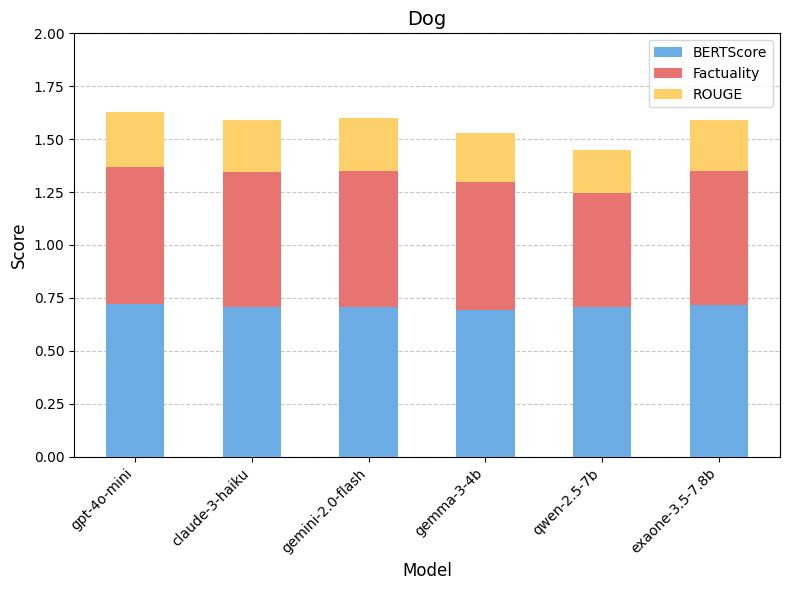

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 첫 번째 이미지의 표에서 데이터를 추출하여 DataFrame으로 만듭니다.
# 'Dog' 컬럼의 'preprocessed' 데이터를 사용합니다.
data = {
    'Model': ['gpt-4o-mini', 'claude-3-haiku', 'gemini-2.0-flash', 'gemma-3-4b', 'qwen-2.5-7b', 'exaone-3.5-7.8b'],
    'ROUGE': [0.261, 0.248, 0.253, 0.234, 0.202, 0.243],
    'BERTScore': [0.723, 0.705, 0.708, 0.694, 0.707, 0.715],
    'Factuality': [0.646, 0.638, 0.640, 0.602, 0.540, 0.634]
}
df = pd.DataFrame(data)

# 각 지표를 누적하여 그래프를 그립니다.
# 일반적으로 BERTScore가 가장 크고, ROUGE와 Factuality는 그보다 작으므로
# BERTScore, Factuality, ROUGE 순으로 누적하여 그리는 것이 두 번째 이미지와 유사합니다.
# (단, 두 번째 이미지의 y축 스케일은 각 지표의 값 합계와 일치하는 것으로 보입니다.)

# 스택 바 차트를 위한 각 지표의 시작 위치 계산
# BERTScore가 가장 아래에, 그 위에 Factuality, 그 위에 ROUGE가 쌓이도록 합니다.
df['BERTScore_bottom'] = 0
df['Factuality_bottom'] = df['BERTScore']
df['ROUGE_bottom'] = df['BERTScore'] + df['Factuality']

# 그래프 생성
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.5

# BERTScore 바
ax.bar(df['Model'], df['BERTScore'], bar_width, label='BERTScore', color='#6cace4', bottom=df['BERTScore_bottom'], zorder=3)
# Factuality 바
ax.bar(df['Model'], df['Factuality'], bar_width, label='Factuality', color='#e77471', bottom=df['Factuality_bottom'], zorder=3)
# ROUGE 바
ax.bar(df['Model'], df['ROUGE'], bar_width, label='ROUGE', color='#fdd069', bottom=df['ROUGE_bottom'], zorder=3)

y_ticks = np.arange(0, 2.25, 0.25) # 0부터 2.0까지 0.25 간격으로 (상한 포함을 위해 2.25로 설정)
ax.set_yticks(y_ticks)
ax.yaxis.grid(True, linestyle='--', alpha=0.7) # 가로선을 점선이 아닌 실선으로, 투명도 조정

# 레이블 및 제목 설정
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Dog', fontsize=14)
ax.set_ylim(0, 2.0)

# x축 레이블 회전 (모델 이름이 길 경우)
plt.xticks(rotation=45, ha='right')

# 범례 표시
ax.legend(loc='upper right') # 범례 위치 조정

plt.tight_layout() # 레이아웃 자동 조정
plt.show()

/home/work/factchecking/miniconda3/envs/vllm/bin/python


In [1]:
def parse_atomic_facts_output(text):
    """
    주어진 텍스트에서 '문장: ~' 부분을 제외하고 원자적 사실 목록을 추출합니다.
    예시:
    "문장: Thierry Henry is a French professional football coach.
    - Thierry Henry is a French coach.
    - Thierry Henry is a professional coach.
    - Thierry Henry is a football coach."
    -> ["Thierry Henry is a French coach.", "Thierry Henry is a professional coach.", "Thierry Henry is a football coach."]
    """
    lines = text.strip().split('\n')
    atomic_facts = []

    # 첫 번째 줄이 '문장: ~' 형식일 경우 건너뜁니다.
    # 그 외의 경우, 모든 줄을 원자적 사실로 간주합니다.
    start_index = 0
    if lines and lines[0].startswith("문장:"):
        start_index = 1

    for i in range(start_index, len(lines)):
        line = lines[i].strip()
        if line.startswith('- '):
            fact = line[2:].strip() # '- ' 부분을 제거하고 공백을 정리합니다.
            # 마지막 문자가 마침표가 아니면 추가합니다 (필요에 따라).
            if fact and fact[-1] != '.':
                fact += '.'
            atomic_facts.append(fact)
        elif line: # '- '로 시작하지 않지만 내용이 있는 줄도 사실로 간주할 경우 (선택 사항)
            # 이 부분은 필요에 따라 주석 처리하거나 수정할 수 있습니다.
            # 현재는 '- '로 시작하는 줄만 처리하도록 되어 있습니다.
            pass
            
    return atomic_facts

# 사용 예시:
text_example = """문장: Thierry Henry is a French professional football coach.
- Thierry Henry is a French coach.
- Thierry Henry is a professional coach.
- Thierry Henry is a football coach.
- He was born in 1977.
"""

facts = parse_atomic_facts_output(text_example)
print(facts)

text_example_no_sentence_header = """- Atomic fact one.
- Atomic fact two.
- Another fact."""

facts_no_header = parse_atomic_facts_output(text_example_no_sentence_header)
print(facts_no_header)

['Thierry Henry is a French coach.', 'Thierry Henry is a professional coach.', 'Thierry Henry is a football coach.', 'He was born in 1977.']
['Atomic fact one.', 'Atomic fact two.', 'Another fact.']


In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

use_raw_format = False
model_name = "exaone-3.5-7.8b"
suffix = "raw" if use_raw_format else "preprocessed"
fintuned_path = f'data/outputs/{model_name}_petqa_{suffix}/best_model'

system_prompt = "당신은 반려동물(개, 고양이) 의료 상담 전문 수의사입니다.\n당신의 역할은 개(강아지), 고양이 관련 의료 질문에 대해 유용하고, 완전하며, 전문적인 지식에 기반한 정확한 답변을 하는 것입니다.\n질문에 대해 차근차근 생각하며 답변하고, 답변 문장의 개수는 최대 5개를 넘지 마세요."
        

model = AutoModelForCausalLM.from_pretrained(
    fintuned_path,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    fintuned_path,
)

def generate_answer(model, tokenizer, question, system_prompt=None):
    """질문에 대한 답변 생성"""
    
    system_prompt = "당신은 반려동물(개, 고양이) 의료 상담 전문 수의사입니다.\n당신의 역할은 개(강아지), 고양이 관련 의료 질문에 대해 유용하고, 완전하며, 전문적인 지식에 기반한 정확한 답변을 하는 것입니다.\n질문에 대해 차근차근 생각하며 답변하고, 답변 문장의 개수는 최대 5개를 넘지 마세요."
    
    # 메시지 구성
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]
    
    # 채팅 템플릿 적용
    prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )
    
    # 토큰화
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        truncation=True, 
        max_length=4096
    )
    
    # GPU로 이동 (모델이 GPU에 있는 경우)
    if model.device.type == 'cuda':
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # 답변 생성
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=2048,
            do_sample=False,
            temperature=0,
        )
    
    # 생성된 텍스트 디코딩 (입력 프롬프트 제외)
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    return generated_text.strip()

/home/work/factchecking/miniconda3/envs/vllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


증상이 경한 감기일 수도 있지만, 심혈관계 질환이나 다른 질환일 수도 있습니다. 병원에 내원하여 검사받기를 권장합니다.


In [17]:
question = "질문: 강아지(코카 스파니엘, 4세, 11kg)가 2주 전부터 온몸이 뻣뻣해지며 경련을 일으켰고, 경련 후에는 밥을 먹지 않습니다. 최근에도 또 경련을 일으켰습니다. 어디에 문제가 있는지, 예상되는 질병은 무엇인지 알려주십시오.\n답변: "
print(generate_answer(model, tokenizer, question))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


경련의 원인은 다양하며, 뇌수두증, 후두골 이형성, 소뇌형성 부전, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌수막염, 뇌척수염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양, 뇌수막염, 뇌수두증, 후두골형성 부전, 뇌수두증, 뇌종양,

In [20]:
def evaluate_on_train_samples(model, tokenizer, train_data, formatting_func, num_samples=5, device="cuda"):
    """
    학습에 사용된 train set 일부 샘플에 대해 모델 응답을 확인하는 함수
    """
    model.eval()
    model.to(device)

    print("=" * 50)
    print(f"Train 샘플 {num_samples}개에 대해 모델 응답 확인")
    print("=" * 50)

    for i in range(num_samples):
        sample = train_data[i]
        prompt = formatting_func(sample)
        
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            output_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=256,
                do_sample=True,
                temperature=0.8,
                top_p=0.95,
                top_k=50,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id
            )

        decoded_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        print(f"\n[Sample {i+1}]")
        print("-" * 30)
        print("[Prompt]")
        print(prompt)
        print("\n[Generated Answer]")
        print(decoded_output.replace(prompt, "").strip())  # 출력에서 프롬프트 제거
        print("-" * 30)


'[PAD]'

In [3]:
import json
file_path = "data/eval/output_exaone-3.5-7.8b_petqa_0.json"
with open(file_path, 'r') as f:
    try:
        data = json.load(f)
        print("✅ Valid JSON format")
    except json.JSONDecodeError as e:
        print(f"❌ JSON decode error: {e}")


✅ Valid JSON format


In [1]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")


2
NVIDIA H100 80GB HBM3


In [10]:
def generate_answer(model, tokenizer, question, system_prompt=None):
    """질문에 대한 답변 생성"""
    
    # 기본 시스템 프롬프트 설정
    if system_prompt is None:
        system_prompt = "당신은 반려동물(개, 고양이) 의료 상담 전문 수의사입니다.\n당신의 역할은 개(강아지), 고양이 관련 의료 질문에 대해 유용하고, 완전하며, 전문적인 지식에 기반한 정확한 답변을 하는 것입니다.\n답변 외의 문장은 포함하지 마세요."
    
    # 메시지 구성
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]
    
    # 채팅 템플릿 적용
    prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )
    
    # 토큰화
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        truncation=True, 
        max_length=4096
    )
    
    # GPU로 이동 (모델이 GPU에 있는 경우)
    if model.device.type == 'cuda':
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # 답변 생성
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=2048,
            do_sample=True,
            temperature=0.1,
            top_p=0.1,
            top_k=50,
            repetition_penalty=1.2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            use_cache=True
        )
    
    # 생성된 텍스트 디코딩 (입력 프롬프트 제외)
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    return generated_text.strip()

In [ ]:
model_id = "LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct"
model_name = "exaone-3.5-7.8b"
finetuned_path = f"data/outputs/{model_name}_petqa/best_model"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
)


ValueError: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`

In [7]:
model.device

device(type='cuda', index=0)

In [10]:
question = "강아지가 쓸개골 탈구가 의심됩니다. 앞으로 산책을 꾸준히 하면 탈구가 예방될까요?"
print(generate_answer(model, tokenizer, question))

무릎골탈구 단계는 촉진 검사와 방사선 검사를 통한 종합적인 분석이 필요합니다. 무릎골탈구는 정도에 따라 1기~4기로 구분되며, 일반적으로 1기와 2기는 겉으로 확인하기 어렵고 3기에서는 수술을 추천드립니다. 진행된다면 파행 증상이 심해지고 자세 이상 및 퇴행성 관절염이 동반됩니다. 하루 30분 이상 꾸준한 산책과 체중 조절로 관절을 보호해야 하고 과격한 운동과 점프 같은 행동은 피해야 합니다. 관절 보조제를 통해 최대한 진행을 차단하시기 바랍니다. 주기적으로 병원에서 상황을 체크하시길 권장합니다.


In [3]:
train_dir = "./data/training"
train_path = os.path.join(train_dir, f"train.json")
validation_path = os.path.join(train_dir, f"validation.json")

data_files = {
    "train": train_path,
    "validation": validation_path
}

def load_datasets(data_files):
    dataset = load_dataset("json", data_files=data_files)
    
    train_data = dataset["train"]
    validation_data = dataset["validation"]
    
    return train_data, validation_data